In [ ]:
%pip install albumentations opencv-python matplotlib numpy pandas tqdm pillow rich scikit-image scikit-learn

In [4]:
import lzma
import os
import pickle
import re
import shutil
import tarfile
from collections import Counter
from typing import Any, Callable

import albumentations as A
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import tqdm
from PIL import Image
from rich import print
from skimage import feature, transform
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split


# **Data preprocessing**

In [5]:
# Replace 'your_file.tgz' with the actual name of your uploaded file
file_path = '/kaggle/input/lfw-dataset/lfw-funneled.tgz'

with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall('/kaggle/working/Raw/')

In [6]:
def identity(x):
    return x

In [7]:
def visualize_image(axes_array, images_array, labels_array, figure):
    axes_array = axes_array.flatten()

    # assert len(axes_array) == len(images_array) == len(labels_array)
    assert len(axes_array) <= len(images_array)
    assert len(axes_array) <= len(labels_array)

    for i, ax in enumerate(axes_array):
        img = ax.imshow(images_array[i], cmap="gray")
        figure.colorbar(img, ax=ax)
        ax.set_title(labels_array[i])
        ax.axis("off")


In [8]:
class LazyData:
    def __init__(
        self,
        filename: str,
        load_strategy: str | Callable[[str | bytes], Any] | None = None,
    ):
        self._filename = filename
        self._data = None
        self._load_strategy = load_strategy

    def __call__(self):
        if self._data is None:
            self._build_data()
        return self._data

    def __load_strategy_image(buf) -> np.ndarray[np.uint8]:
        img = mpimg.imread(buf, format="jpg")
        return img

    def _build_data(self):
        with open(self._filename, "rb") as f:
            if self._load_strategy is None:
                self._data = f.read()
            elif self._load_strategy == "image":
                self._data = LazyData.__load_strategy_image(self._filename)
            else:
                buf = f.read()
                self._data = self._load_strategy(buf)


def dataset(
    path: str,
    min_faces: int | None = 20,
    max_faces: int | None = None,
    hard_limit: bool = False,
    shuffle: bool = False,
    random_state: int | None = None,
    verbose: bool | None = True,
):
    if random_state is not None:
        np.random.seed(random_state)

    excluded_dirs = []
    capped_dirs = []
    capped_counts = {}
    for direc in os.listdir(path):
        if os.path.isdir(os.path.join(path, direc)):
            if min_faces is not None:
                if len(os.listdir(os.path.join(path, direc))) < min_faces:
                    excluded_dirs.append(direc)
            if max_faces is not None:
                if len(os.listdir(os.path.join(path, direc))) > max_faces:
                    if hard_limit:
                        excluded_dirs.append(direc)
                    else:
                        capped_dirs.append(direc)

    ds = []
    tracker = tqdm.tqdm if verbose else identity
    pattern = re.compile(r"(.*)_(?:\d{4}).jpg")

    for root, dirs, files in tracker(os.walk(path)):
        for file in files:
            if file.endswith(".jpg"):
                match = pattern.match(file)
                if match:
                    target = match.group(1)

                if target in excluded_dirs:
                    continue

                if max_faces is not None:
                    if target in capped_dirs:
                        if target not in capped_counts:
                            capped_counts[target] = 0
                        capped_counts[target] += 1
                        if capped_counts[target] > max_faces:
                            continue

                ds.append(
                    [
                        LazyData(
                            os.path.abspath(os.path.join(root, file)),
                            load_strategy="image",
                        ),
                        target,
                    ]
                )

    if shuffle:
        np.random.shuffle(ds)

    return np.array(ds)


def fetch_lfw_people(
    path_to_dataset: str = "Dataset/Raw",
    min_faces: int | None = 20,
    max_faces: int | None = None,
    hard_limit: bool = False,
    shuffle: bool = True,
    random_state: int | None = None,
    verbose: bool = True,
):
    dst = dataset(
        path_to_dataset,
        min_faces=min_faces,
        max_faces=max_faces,
        hard_limit=hard_limit,
        shuffle=shuffle,
        random_state=random_state,
        verbose=verbose,
    )
    X = dst[:, 0]
    Y = dst[:, 1]
    return X, Y


5750it [00:00, 5797.94it/s] 


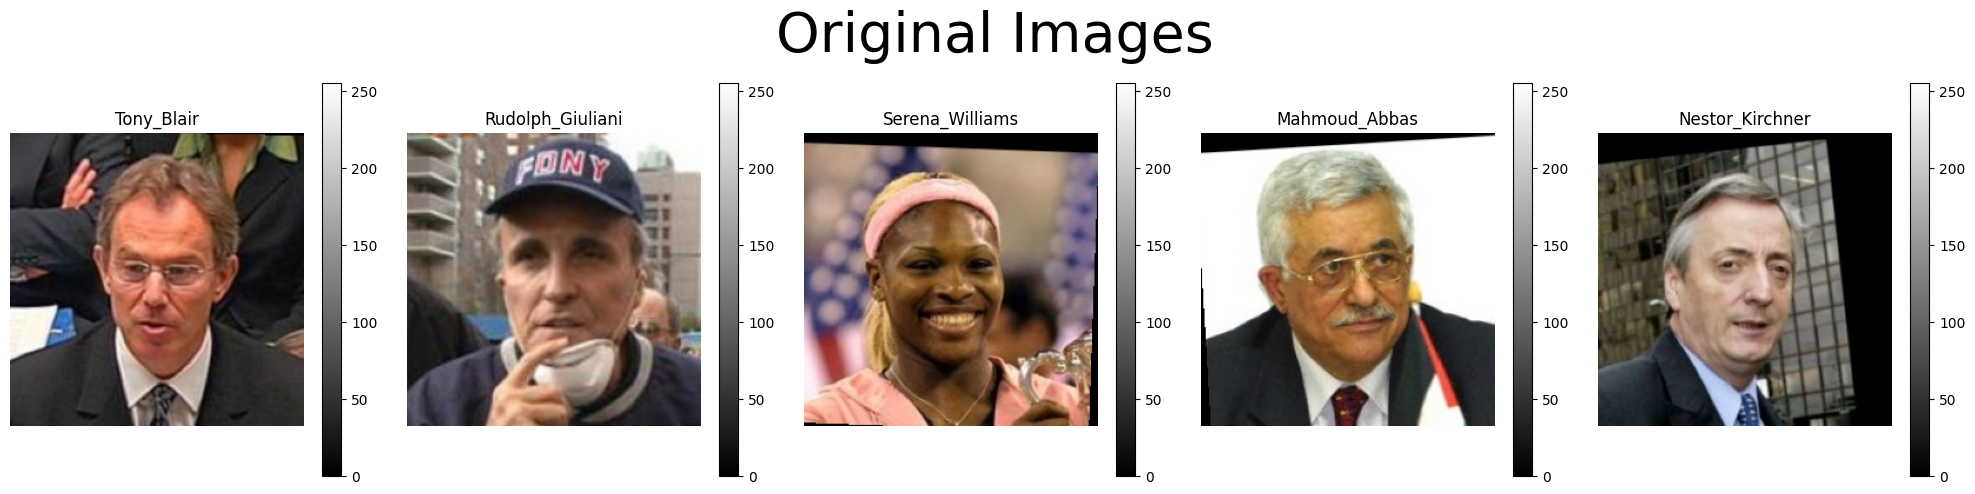

In [9]:
X, Y = fetch_lfw_people(path_to_dataset="/kaggle/working/Raw/lfw_funneled")
__x = []
for x in range(5):
    __x.append(X[x]())

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
axes = axes.flatten()
visualize_image(axes, __x, Y, fig)
plt.suptitle("Original Images", size=40)
plt.tight_layout()
plt.show()

In [10]:
default_transform = A.Compose(
    [
        A.RandomCrop(width=200, height=200),
        A.HorizontalFlip(p=0.5),
        # A.RandomScale(scale_limit=(-0.5, 2.0), p=0.5),
        A.ShiftScaleRotate(p=0.5, shift_limit=0.1, scale_limit=0.2, rotate_limit=15),
        A.RandomBrightnessContrast(p=0.2),
        A.Blur(blur_limit=3, p=0.2),
    ]
)


def augment_data(
    img: np.ndarray,
    augmentation_count: int = 10,
    augmentation_pipeline=None,
    desired_shape: tuple[int, int] = (250, 250),
) -> list[np.ndarray]:
    images = []
    if augmentation_pipeline is None:
        augmentation_pipeline = default_transform
    for _ in range(augmentation_count):
        aug_image = augmentation_pipeline(image=img)["image"]
        aug_image = Image.fromarray(aug_image).resize(desired_shape)
        aug_image = np.array(aug_image)
        images.append(aug_image)
    return images

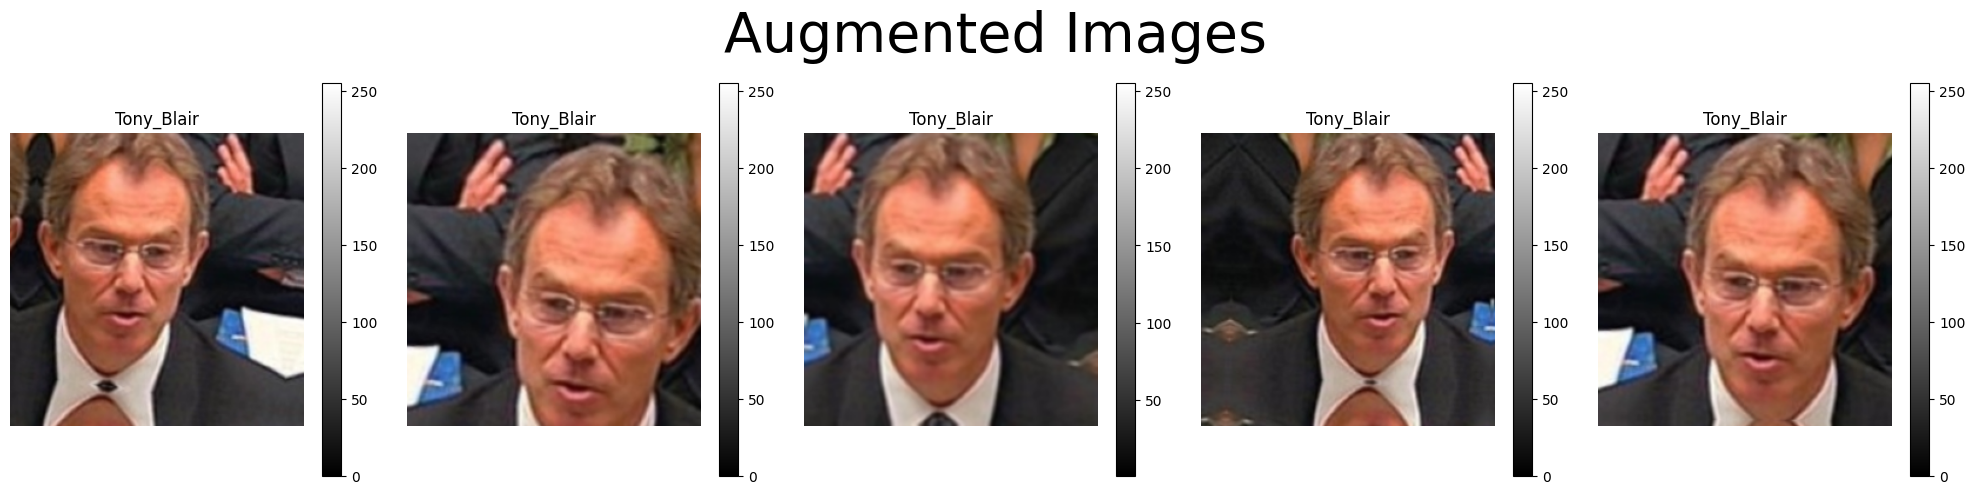

In [11]:
aug_data = augment_data(
    __x[0],
    augmentation_count = 5,
)

aug_Y = [Y[0]] * 5

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
axes = axes.flatten()
visualize_image(axes, aug_data, aug_Y, fig)
fig.suptitle("Augmented Images", size=40)
plt.tight_layout()
plt.show()

In [38]:
def dump_test_files(x_test, y_test, path_prefix: str, verbose=True):
    # clear out the directory
    if os.path.exists(path_prefix):
        shutil.rmtree(path_prefix)

    if os.path.exists(path_prefix + ".zip"):
        os.remove(path_prefix + ".zip")

    os.makedirs(path_prefix)

    freq_table = {}
    for i, x in enumerate(x_test):
        target = y_test[i]
        if target not in freq_table:
            freq_table[target] = 0
            os.makedirs(os.path.join(path_prefix, str(target)))
        freq_table[target] += 1

        # write image as jpeg
        Image.fromarray(x).save(
            os.path.join(
                path_prefix, str(target), f"{target}_{freq_table[target]:04}.jpg"
            )
        )

    shutil.make_archive(path_prefix, "zip", path_prefix)
    if verbose:
        print("[bold green]Test files dumped successfully[/bold green]")


def export_dataset_objects(
    path_to_dataset: str = "Dataset/Raw",
    min_faces: int | None = 20,
    max_faces: int | None = None,
    hard_limit: bool = False,
    shuffle=True,
    random_state=None,
    test_size=0.2,
    verbose=True,
    augment=True,
    desired_shape: tuple[int, int] = (250, 250),
    augmentation_count: int = 10,
    augmentation_upto: int | None = None,
    augmentation_pipeline=None,
    experimental_export: bool = True,
):
    X, Y = fetch_lfw_people(
        path_to_dataset=path_to_dataset,
        min_faces=min_faces,
        max_faces=max_faces,
        hard_limit=hard_limit,
        shuffle=shuffle,
        random_state=random_state,
        verbose=verbose,
    )

    log = print if verbose else identity

    log("[bold green]Dataset loaded successfully[/bold green]")

    export_path = os.path.dirname(path_to_dataset)

    tracker = tqdm.tqdm if verbose else identity

    # print(sys.getsizeof(X[0]))
    # exit(1)

    __x = []
    for x in tracker(X):
        __x.append(x())
    # # exit(1)

    __x = np.array(__x, copy=False)
    log("[bold green]Binary data loaded successfully[/bold green]")
    # __x = np.zeros((X.shape[0], 250, 250, 3), dtype=np.uint8)
    # print(__x.shape)
    # for i, x in tracker(enumerate(X)):
    #     __x[i] = x()

    x_train, x_test, y_train, y_test = train_test_split(
        __x,
        Y,
        test_size=test_size,
        random_state=random_state,
        stratify=Y,
    )

    log("[bold green]Dataset split successfully[/bold green]")

    if augment:
        if augmentation_upto is None:
            xy = []
            for i, x in tracker(enumerate(x_train)):
                aug_data = augment_data(
                    x,
                    desired_shape=desired_shape,
                    augmentation_count=augmentation_count,
                    augmentation_pipeline=augmentation_pipeline,
                )

                for data in aug_data:
                    data = Image.fromarray(data).convert("L")
                    data = np.array(data, copy=False)
                    xy.append([data, y_train[i]])
                # print(xy)
                # fig, axes = plt.subplots(2, 5, figsize=(20, 10))
                # axes = axes.flatten()

                # for img, ax in zip(aug_data, axes):
                #     ax.imshow(img)
                #     ax.axis("off")
                # plt.tight_layout()
                # plt.show()

                # exit(1)
            log("[bold green]Augmentation done successfully[/bold green]")
            xy_data = np.array(xy, dtype=object, copy=False)
            log("[bold green]Augmented data converted to numpy array[/bold green]")
            if shuffle:
                np.random.shuffle(xy_data)
                log("[bold green]Augmented data shuffled successfully[/bold green]")

            x_train_data = xy_data[:, 0]
            log("[bold green]x_train_data split successfully[/bold green]")
            y_train_data = xy_data[:, 1]
            log("[bold green]y_train_data split successfully[/bold green]")
#             x_train_data = x_train_data / 255
            log("[bold green]x_train_data normalized successfully[/bold green]")
#             x_test = x_test / 255
            log("[bold green]x_test normalized successfully[/bold green]")
            if not experimental_export:
                x_train_data.dump(os.path.join(export_path, "x_train.npy"))
                y_train_data.dump(os.path.join(export_path, "y_train.npy"))
                x_test.dump(os.path.join(export_path, "x_test.npy"))
                y_test.dump(os.path.join(export_path, "y_test.npy"))
            else:
                np.savez_compressed(
                    os.path.join(export_path, "data.npz"),
                    x_train=x_train_data,
                    y_train=y_train_data,
                    x_test=x_test,
                    y_test=y_test,
                )
#                 np.save(
#                     os.path.join(export_path, "x_train.npy"),
#                     x_train_data,
#                 )

#                 np.save(
#                     os.path.join(export_path, "y_train.npy"),
#                     y_train_data,
#                 )

#                 np.save(
#                     os.path.join(export_path, "x_test.npy"),
#                     x_test,
#                 )

#                 np.save(
#                     os.path.join(export_path, "y_test.npy"),
#                     y_test,
#                 )
                log("[bold green]Dataset exported successfully[/bold green]")

            # og_data = np.array(__x)
            # og_data.dump("Dataset/x_og.npy")
            # y_data.dump("Dataset/y.npy")
        else:
            xy = []
            idents = {}
            for i, y in enumerate(y_train):
                if y in idents:
                    idents[y].append(i)
                else:
                    idents[y] = [i]
            log("[bold green]Identified classes successfully[/bold green]")

            if augmentation_upto == 0:
                # augment upto max_faces
                if max_faces is None:
                    raise Exception("max_faces must be int if augmentation_upto is 0")

                for y in idents:
                    augmentation_len = max_faces - len(idents[y])
                    for _k in range(augmentation_len):
                        # choose random image
                        random_image = np.random.choice(idents[y])
                        # augment it
                        aug_data = augment_data(
                            x_train[random_image],
                            desired_shape=desired_shape,
                            augmentation_count=1,
                            augmentation_pipeline=augmentation_pipeline,
                        )
                        aug_image = aug_data[0]
                        aug_image = Image.fromarray(aug_image).convert("L")
                        aug_image = np.array(aug_image, copy=False)
                        # add it to the dataset
                        xy.append([aug_image, y])
                    log(
                        "[bold green]Augmented upto max_faces successfully[/bold green]"
                    )
            elif augmentation_upto > 0:
                # augment upto augmentation_upto
                for y in idents:
                    faces = len(idents[y])
                    if augmentation_upto > faces:
                        augmentation_len = augmentation_upto - len(idents[y])
                        for _k in range(augmentation_len):
                            # choose random image
                            random_image = np.random.choice(idents[y])
                            # augment it
                            aug_data = augment_data(
                                x_train[random_image],
                                desired_shape=desired_shape,
                                augmentation_count=1,
                                augmentation_pipeline=augmentation_pipeline,
                            )
                            aug_image = aug_data[0]
                            aug_image = Image.fromarray(aug_image).convert("L")
                            aug_image = np.array(aug_image, copy=False)
                            # add it to the dataset
                            xy.append([aug_image, y])
                log(
                    "[bold green]Augmented upto augmentation_upto successfully[/bold green]"
                )
            else:
                raise Exception("augmentation_upto must be bool or int")

            # add the original image with the label
            for i, x in tracker(enumerate(x_train)):
                cv_image = Image.fromarray(x).convert("L")
                cv_image = np.array(cv_image, copy=False)
                xy.append([cv_image, y_train[i]])
            log("[bold green]Original images added successfully[/bold green]")

            xy_data = np.array(xy, dtype=object, copy=False)
            log("[bold green]Augmented data converted to numpy array[/bold green]")
            if shuffle:
                np.random.shuffle(xy_data)
                log("[bold green]Augmented data shuffled successfully[/bold green]")
            x_train_data = xy_data[:, 0]
            log("[bold green]x_train_data split successfully[/bold green]")
            y_train_data = xy_data[:, 1]
            log("[bold green]y_train_data split successfully[/bold green]")
#             x_train_data = x_train_data / 255
            log("[bold green]x_train_data normalized successfully[/bold green]")
#             x_test = x_test / 255
            log("[bold green]x_test normalized successfully[/bold green]")

            if not experimental_export:
                x_train_data.dump(os.path.join(export_path, "x_train.npy"))
                y_train_data.dump(os.path.join(export_path, "y_train.npy"))
                x_test.dump(os.path.join(export_path, "x_test.npy"))
                y_test.dump(os.path.join(export_path, "y_test.npy"))
            else:
                np.savez_compressed(
                    os.path.join(export_path, "data.npz"),
                    x_train=x_train_data,
                    y_train=y_train_data,
                    x_test=x_test,
                    y_test=y_test,
                )

#                 np.save(
#                     os.path.join(export_path, "x_train.npy"),
#                     x_train_data,
#                 )

#                 np.save(
#                     os.path.join(export_path, "y_train.npy"),
#                     y_train_data,
#                 )

#                 np.save(
#                     os.path.join(export_path, "x_test.npy"),
#                     x_test,
#                 )

#                 np.save(
#                     os.path.join(export_path, "y_test.npy"),
#                     y_test,
#                 )
                log("[bold green]Dataset exported successfully[/bold green]")

    else:
        # x_data = np.array(__x)
        # x_data.dump("Dataset/x.npy")
        # Y.dump("Dataset/y.npy")
#         x_train = x_train / 255
#         x_test = x_test / 255

        if not experimental_export:
            x_train.dump(os.path.join(export_path, "x_train.npy"))
            y_train.dump(os.path.join(export_path, "y_train.npy"))
            x_test.dump(os.path.join(export_path, "x_test.npy"))
            y_test.dump(os.path.join(export_path, "y_test.npy"))
        else:
            np.savez_compressed(
                os.path.join(export_path, "data.npz"),
                x_train=x_train,
                y_train=y_train,
                x_test=x_test,
                y_test=y_test,
            )
#             np.save(
#                 os.path.join(export_path, "x_train.npy"),x_train,
#             )

#             np.save(
#                 os.path.join(export_path, "y_train.npy"),
#                 y_train,
#             )

#             np.save(
#                 os.path.join(export_path, "x_test.npy"),
#             x_test,
#             )

#             np.save(
#                 os.path.join(export_path, "y_test.npy"),
#             y_test,
#             )



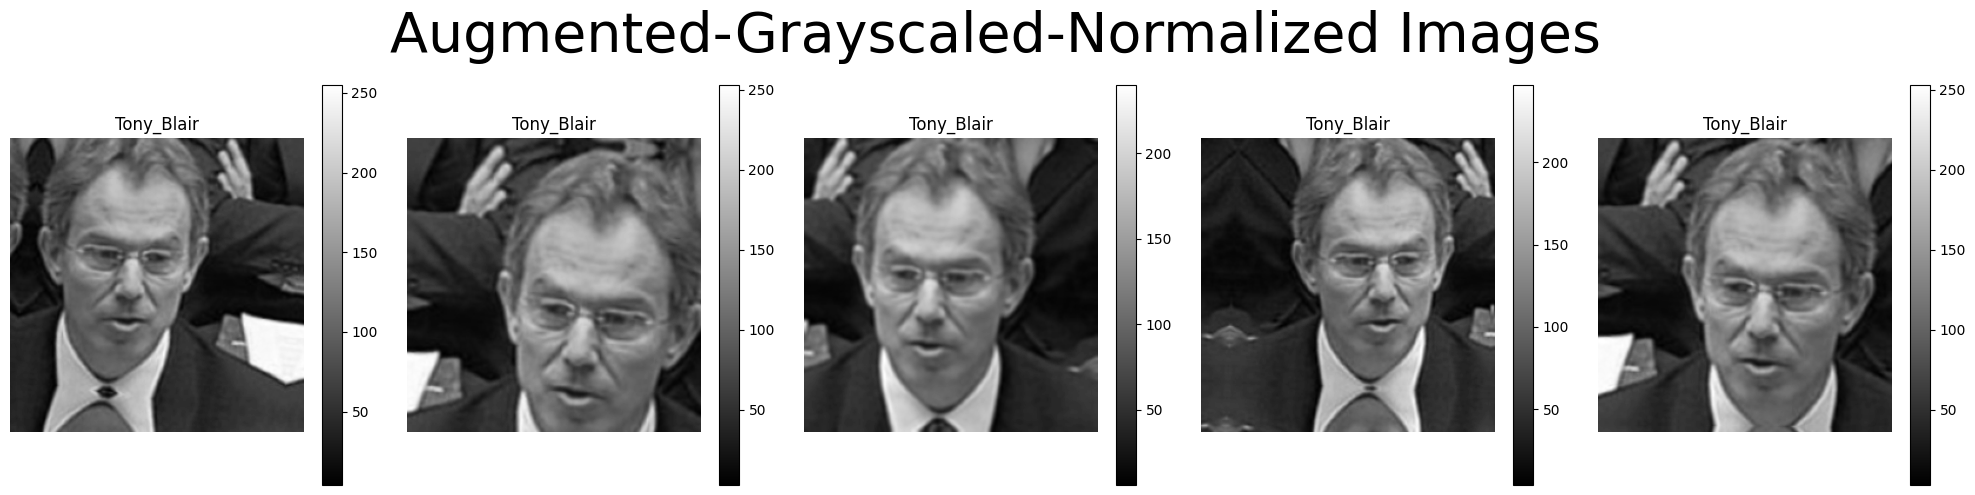

In [39]:
aug_data = np.array(aug_data)
gs_aug_data = []
for data in aug_data:
    img = Image.fromarray(data).convert("L")
    img = np.array(img)
    gs_aug_data.append(img)
gs_aug_data = np.array(gs_aug_data)
# gs_aug_data = gs_aug_data / 255

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
axes = axes.flatten()
visualize_image(axes, gs_aug_data, aug_Y, fig)
plt.suptitle("Augmented-Grayscaled-Normalized Images", size=40)
plt.tight_layout()
plt.show()

In [40]:
# del X
# del __x
# del Y
# del fig
# del axes

In [41]:
export_dataset_objects(
        path_to_dataset="/kaggle/working/Raw/lfw_funneled",
        shuffle=False,
        min_faces=20,
        max_faces=None,
        hard_limit=False,
        augment=True,
        augmentation_upto=250,
        experimental_export=True,
    )

5750it [00:01, 5481.61it/s] 


Dataset loaded successfully

100%|██████████| 3023/3023 [00:06<00:00, 481.68it/s]


Binary data loaded successfully

Dataset split successfully

Identified classes successfully

Augmented upto augmentation_upto successfully

2418it [00:00, 3968.39it/s]


Original images added successfully

Augmented data converted to numpy array

x_train_data split successfully

y_train_data split successfully

x_train_data normalized successfully

x_test normalized successfully

Dataset exported successfully

# **Data Feature extraction**

In [42]:
# loaded_data = np.load('/kaggle/input/face-set1/compressed_x_test.npz',allow_pickle=True)['data']

In [43]:
# x_train_data = np.load("/kaggle/working/Raw/x_train.npz", allow_pickle=True)
# y_train_data = np.load("/kaggle/working/Raw/y_train.npz", allow_pickle=True)
# x_test_data = np.load("/kaggle/working/Raw/x_test.npz", allow_pickle=True)
# y_test_data = np.load("/kaggle/working/Raw/y_test.npz", allow_pickle=True)
# X = np.load("/kaggle/working/Raw/x_train.npy", allow_pickle=True)
# Y = np.load("/kaggle/working/Raw/y_train.npy", allow_pickle=True)
# x_test = np.load("/kaggle/working/Raw/x_test.npy", allow_pickle=True)
# y_test = np.load("/kaggle/working/Raw/y_test.npy", allow_pickle=True)
data = np.load("/kaggle/working/Raw/data.npz", allow_pickle=True)

In [44]:
X = data['x_train']
Y = data['y_train']
x_test = data['x_test']
y_test = data['y_test']
# x_train = x_train_data['x_train']
# y_train = y_train_data['y_train']
# x_test = x_test_data['x_test']
# y_test = y_test_data['y_test']

In [45]:
print(X.shape)
print(X[0].shape)

(15674,)

(250, 250)

In [46]:
label_counts = Counter(Y)

for label, count in label_counts.items():
    print(f"Label {label}: {count} images")

Label Guillermo_Coria: 250 images

Label Jean_Chretien: 250 images

Label Gray_Davis: 250 images

Label Colin_Powell: 250 images

Label Jiang_Zemin: 250 images

Label Mahmoud_Abbas: 250 images

Label Gerhard_Schroeder: 250 images

Label Lleyton_Hewitt: 250 images

Label Igor_Ivanov: 250 images

Label Tony_Blair: 250 images

Label Hans_Blix: 250 images

Label Serena_Williams: 250 images

Label Tom_Ridge: 250 images

Label Megawati_Sukarnoputri: 250 images

Label Jennifer_Capriati: 250 images

Label Jacques_Chirac: 250 images

Label Bill_Clinton: 250 images

Label Junichiro_Koizumi: 250 images

Label Arnold_Schwarzenegger: 250 images

Label Roh_Moo-hyun: 250 images

Label Donald_Rumsfeld: 250 images

Label Silvio_Berlusconi: 250 images

Label Hugo_Chavez: 250 images

Label Gloria_Macapagal_Arroyo: 250 images

Label Amelie_Mauresmo: 250 images

Label Jack_Straw: 250 images

Label Lindsay_Davenport: 250 images

Label John_Ashcroft: 250 images

Label Tiger_Woods: 250 images

Label Alejandro_Toledo: 250 images

Label Winona_Ryder: 250 images

Label Ariel_Sharon: 250 images

Label George_Robertson: 250 images

Label Jennifer_Aniston: 250 images

Label Jeremy_Greenstock: 250 images

Label Atal_Bihari_Vajpayee: 250 images

Label Angelina_Jolie: 250 images

Label John_Negroponte: 250 images

Label Naomi_Watts: 250 images

Label Recep_Tayyip_Erdogan: 250 images

Label Rudolph_Giuliani: 250 images

Label Vicente_Fox: 250 images

Label Laura_Bush: 250 images

Label Juan_Carlos_Ferrero: 250 images

Label Paul_Bremer: 250 images

Label Pete_Sampras: 250 images

Label David_Beckham: 250 images

Label Carlos_Menem: 250 images

Label Tom_Daschle: 250 images

Label Jose_Maria_Aznar: 250 images

Label Ricardo_Lagos: 250 images

Label Jennifer_Lopez: 250 images

Label Vladimir_Putin: 250 images

Label Luiz_Inacio_Lula_da_Silva: 250 images

Label Nestor_Kirchner: 250 images

Label Alvaro_Uribe: 250 images

Label Hamid_Karzai: 250 images

Label Saddam_Hussein: 250 images

Label Andre_Agassi: 250 images

Label Michael_Bloomberg: 250 images

Label Kofi_Annan: 250 images

Label George_W_Bush: 424 images

In [47]:
# Assuming y_train is your list of labels corresponding to x_train
unique_identities = np.unique(Y)

print(f"There are {len(unique_identities)} unique identities.")

There are 62 unique identities.

In [48]:
# Assuming y_train is your list of labels corresponding to x_train
label_counts = Counter(Y)

# Find the identity with the least number of images
min_label, min_count = min(label_counts.items(), key=lambda x: x[1])

print(f"Identity {min_label} has the least number of images: {min_count} images")

Identity Guillermo_Coria has the least number of images: 250 images

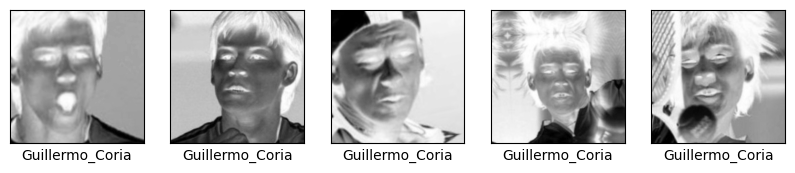

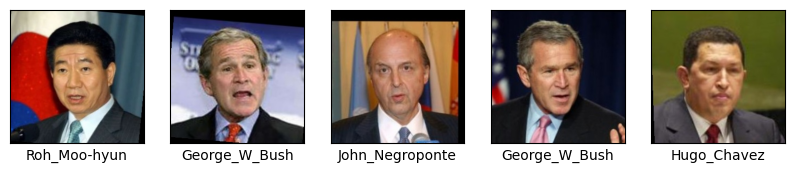

In [49]:
# Function to plot images
def plot_images(images, titles):
    plt.figure(figsize=(10,10))
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(titles[i])
    plt.show()

# Plot images from X
plot_images(X, Y)

# Plot images from x_test
plot_images(x_test, y_test)


# **Feature Extraction Using HOG**

In [50]:
def normalize_images(image_array):
    # Normalize the images and convert them to 8-bit
    for i, image in enumerate(image_array):
        image = ((image - np.min(image)) / (np.max(image) - np.min(image))) * 255
        image = cv2.convertScaleAbs(image)
        image_array[i] = image
    return image_array

# Apply the function to our X and x_test
X_normalized = normalize_images(X)
x_test_normalized = normalize_images(x_test)


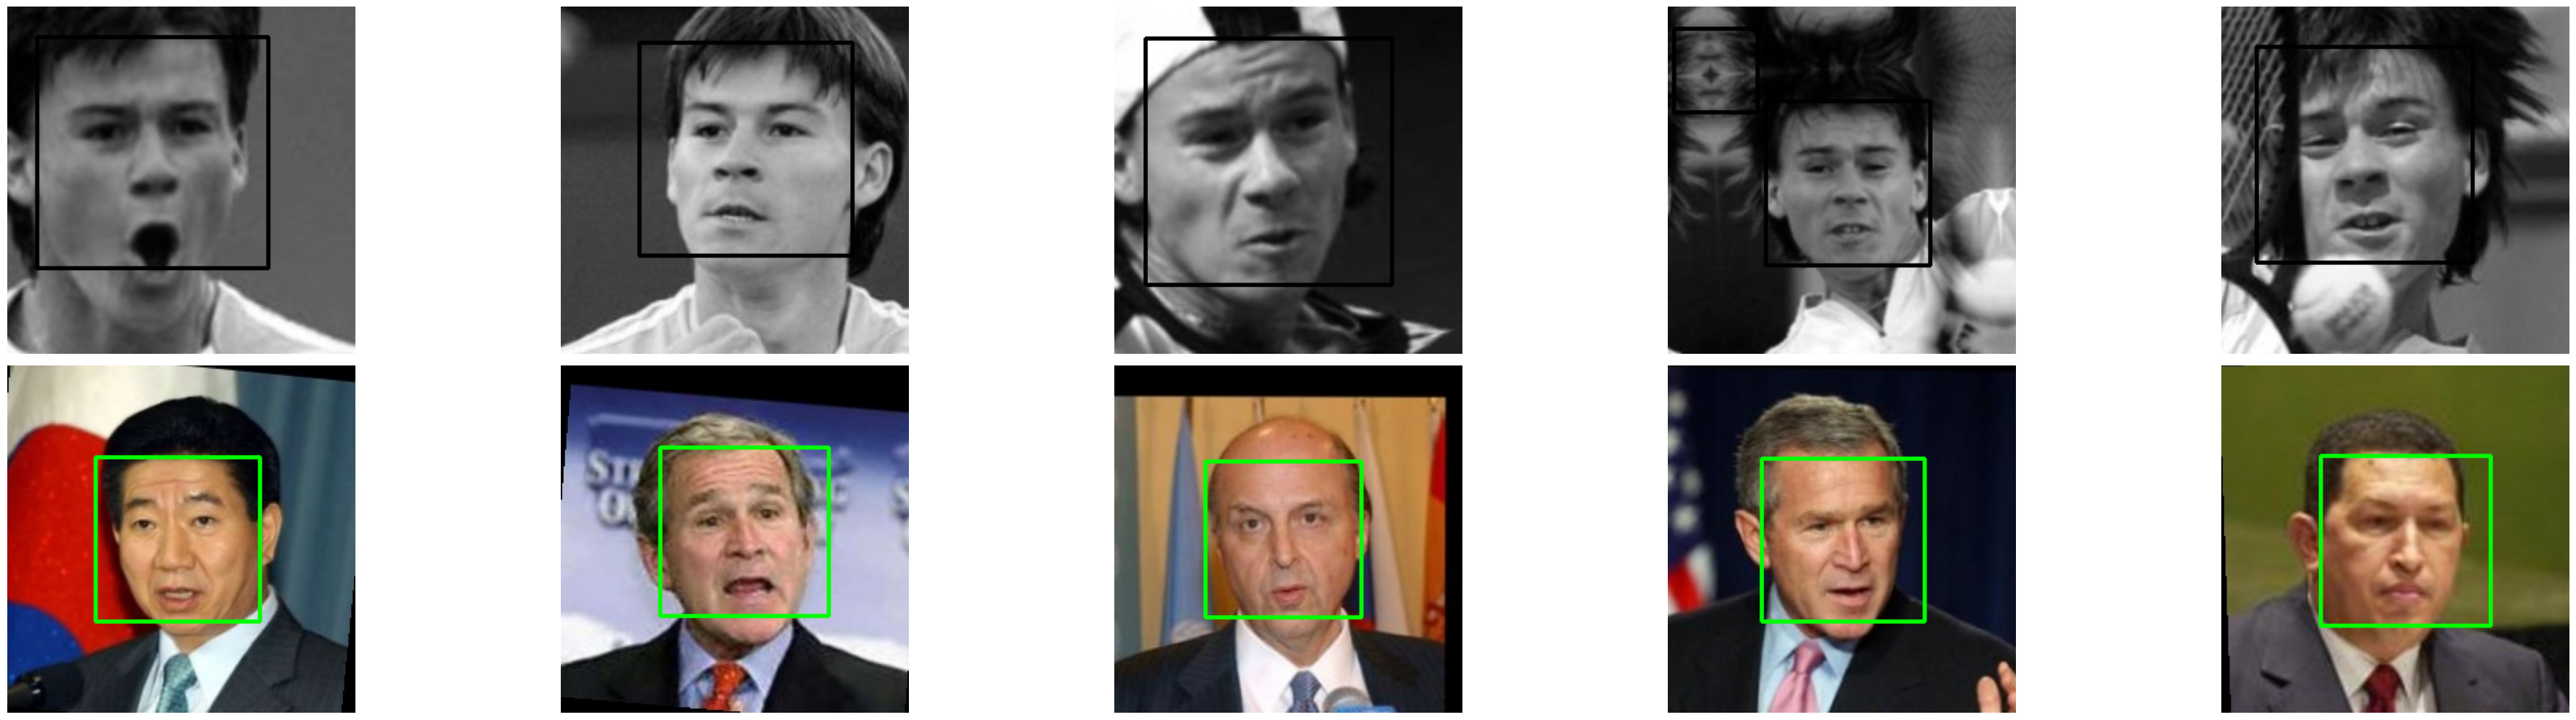

In [54]:
def detect_faces_in_image(input_image):
    # Initialize face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convert the image to 8-bit
    image = cv2.convertScaleAbs(input_image)
    
    # Check if the image is already grayscale
    if len(image.shape) == 3:
        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    for (x, y, w, h) in faces:
        # Draw a rectangle around the face
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
    return image
        
# for i, image in enumerate(X_normalized):
#     if i < 5:
#         detect_faces_in_image(image)

# for i, image in enumerate(x_test_normalized):
#     if i < 5:
#         detect_faces_in_image(image)

img_faces_train = [
    detect_faces_in_image(image) for i, image in enumerate(X_normalized) if i < 5
]
img_faces_test = [
    detect_faces_in_image(image) for i, image in enumerate(x_test_normalized) if i < 5
]

fig, axes = plt.subplots(2, 5, figsize=(40, 10))
axes = axes.flatten()
for i in range(10):
    if i < 5:
        ax = axes[i]
        ax.imshow(img_faces_train[i], cmap="gray")
        ax.axis("off")
    else:
        ax = axes[i]
        ax.imshow(img_faces_test[i - 5])
        ax.axis("off")
plt.tight_layout()
plt.show()

In [55]:
def detect_and_crop_faces_in_image(input_image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convert the image to 8-bit
    image = cv2.convertScaleAbs(input_image)
    
    # Check if the image is already grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    # If a face is detected, crop it out
    if len(faces) > 0:
        x, y, w, h = faces[0]
        cropped_face = image[y:y+h, x:x+w]
        return cropped_face
    return image

final_X = []
final_x_test = []

# Call the function with your images
for image in X_normalized:
    cropped_face = detect_and_crop_faces_in_image(image)
    final_X.append(cropped_face) 

for image in x_test_normalized:
    cropped_face = detect_and_crop_faces_in_image(image)
    final_x_test.append(cropped_face)  


In [56]:
# final_X[:5]

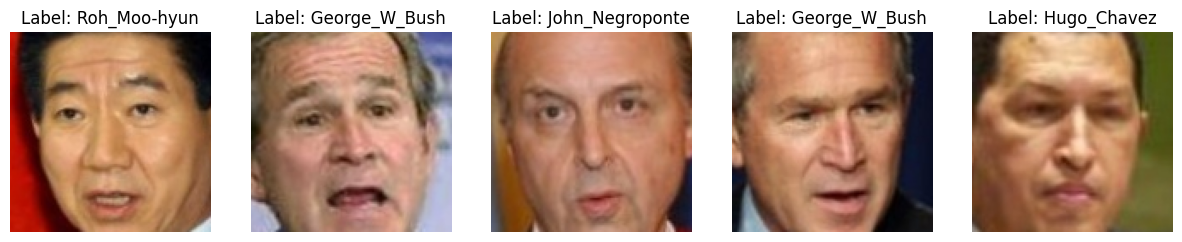

In [57]:
def plot_cropped_image(dataset_images, dataset_labels, num_images=5):
    # Ensure the number of images to plot is not greater than the dataset size
    num_images = min(num_images, len(dataset_images))

    # Create a subplot with a suitable number of rows and columns
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    # Plot each cropped image along with its label
    for i in range(num_images):
        axes[i].imshow(dataset_images[i])  # Assuming dataset_images contains images
        axes[i].set_title(f"Label: {dataset_labels[i]}")
        axes[i].axis('off')

    plt.show()

plot_cropped_image(final_x_test[:5], y_test[:5])


In [58]:
final_x_test[0].shape

(118, 118, 3)

In [74]:
def extract_hog_features(images):
    hog_features_list = []
    hog_images_list = []
    for image in images:
        image_resized = transform.resize(image, (128, 64)) # height:128, width=64
        
        # Check if the image is grayscale or color
        if len(image_resized.shape) == 3 and image_resized.shape[2] == 3:
            # The image is a color image, convert it to grayscale
            image_resized_32 = image_resized.astype(np.float32)
            gray = cv2.cvtColor(image_resized_32, cv2.COLOR_BGR2GRAY)
        else:
            # The image is already grayscale
            gray = image_resized
        
        # Extract HOG features
        hog_features, hog_image = feature.hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
        hog_features_list.append(hog_features)
        hog_images_list.append(hog_image)
    
    return hog_features_list, hog_images_list

hog_features_X, hog_images_X = extract_hog_features(final_X)
hog_features_x_test, hog_images_x_test = extract_hog_features(final_x_test)

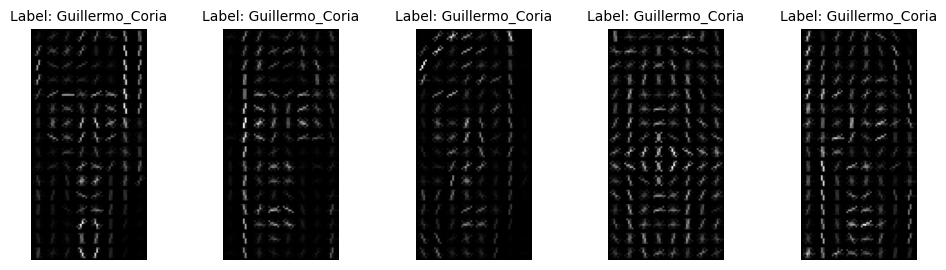

In [80]:
def plot_hog_image(dataset_images, dataset_labels, num_images=5):
    # Ensure the number of images to plot is not greater than the dataset size
    num_images = min(num_images, len(dataset_images))

    # Create a subplot with a suitable number of rows and columns
    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))

    # Plot each cropped image along with its label
    for i in range(num_images):
        axes[i].imshow(dataset_images[i],cmap='gray')  # Assuming dataset_images contains images
        axes[i].set_title(f"Label: {dataset_labels[i]}",size=10)
        axes[i].axis('off')

    plt.show()
    
plot_hog_image(hog_images_X[:5], Y[:5])

In [ ]:
# svm_classifier = svm.SVC(C=10, kernel='rbf', probability=True)

# print(f"Training...")
# svm_classifier.fit(hog_features_X, Y)

# print(f"Evaluating on the validation set...")
# y_pred = svm_classifier.predict(hog_features_x_test)
# print(classification_report(y_test, y_pred))
# accuracy_val = accuracy_score(y_test, y_pred)
# print(f"Validation Accuracy: {accuracy_val}")


In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

svm_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'],'probability':[True]}


svm_classifier = SVC()
svm_grid_search = GridSearchCV(svm_classifier, svm_param_grid, cv=3)
svm_grid_search.fit(hog_features_X, Y)
svm_y_pred = svm_grid_search.predict(hog_features_x_test)
svm_classification_report = classification_report(y_test, svm_y_pred)
svm_accuracy = accuracy_score(y_test, svm_y_pred)
print("Best parameters for SVM:", svm_grid_search.best_params_)
print("Best cross-validated score for SVM:", svm_grid_search.best_score_)
print(f"Accuracy for SVM: {svm_accuracy:.2f}")
print("SVM Metrics:")
print(svm_classification_report)

Best parameters for SVM:
{'C': 10, 'kernel': 'rbf', 'probability': True}

Best cross-validated score for SVM: 0.9064061587911026

Accuracy for SVM: 0.82

SVM Metrics:

precision    recall  f1-score   support

         Alejandro_Toledo       1.00      0.62      0.77         8
             Alvaro_Uribe       0.75      0.86      0.80         7
          Amelie_Mauresmo       0.50      0.25      0.33         4
             Andre_Agassi       0.80      0.57      0.67         7
           Angelina_Jolie       1.00      0.25      0.40         4
             Ariel_Sharon       0.88      0.94      0.91        16
    Arnold_Schwarzenegger       0.50      0.62      0.56         8
     Atal_Bihari_Vajpayee       0.40      0.80      0.53         5
             Bill_Clinton       0.50      0.33      0.40         6
             Carlos_Menem       0.67      0.50      0.57         4
             Colin_Powell       0.98      0.96      0.97        47
            David_Beckham       0.56      0.83      0.67         6
          Donald_Rumsfeld       0.88      0.92      0.90        24
         George_Robertson       1.00      0.75      0.86         4
            George_W_Bush       0.81      0.93      0.87       106
        Gerhard_Schroeder       0.94      0.77      0.85        22
  Gloria_Macapagal_Arroyo       0.73      0.89      0.80         9
               Gray_Davis       0.80      0.80      0.80         5
          Guillermo_Coria       0.67      0.67      0.67         6
             Hamid_Karzai       0.25      0.25      0.25         4
                Hans_Blix       0.78      0.88      0.82         8
              Hugo_Chavez       0.87      0.93      0.90        14
              Igor_Ivanov       1.00      0.25      0.40         4
               Jack_Straw       1.00      0.50      0.67         6
           Jacques_Chirac       0.75      0.82      0.78        11
            Jean_Chretien       0.80      0.73      0.76        11
         Jennifer_Aniston       0.80      1.00      0.89         4
        Jennifer_Capriati       0.83      0.62      0.71         8
           Jennifer_Lopez       1.00      0.75      0.86         4
        Jeremy_Greenstock       0.80      0.80      0.80         5
              Jiang_Zemin       0.67      1.00      0.80         4
            John_Ashcroft       1.00      0.82      0.90        11
          John_Negroponte       0.62      0.83      0.71         6
         Jose_Maria_Aznar       1.00      0.60      0.75         5
      Juan_Carlos_Ferrero       1.00      1.00      1.00         6
        Junichiro_Koizumi       0.92      0.92      0.92        12
               Kofi_Annan       0.86      1.00      0.92         6
               Laura_Bush       0.80      1.00      0.89         8
        Lindsay_Davenport       0.67      1.00      0.80         4
           Lleyton_Hewitt       1.00      0.75      0.86         8
Luiz_Inacio_Lula_da_Silva       1.00      1.00      1.00        10
            Mahmoud_Abbas       0.83      0.83      0.83         6
    Megawati_Sukarnoputri       1.00      0.86      0.92         7
        Michael_Bloomberg       0.75      0.75      0.75         4
              Naomi_Watts       1.00      0.50      0.67         4
          Nestor_Kirchner       0.88      1.00      0.93         7
              Paul_Bremer       1.00      0.75      0.86         4
             Pete_Sampras       1.00      0.75      0.86         4
     Recep_Tayyip_Erdogan       0.71      0.83      0.77         6
            Ricardo_Lagos       1.00      0.60      0.75         5
             Roh_Moo-hyun       1.00      0.67      0.80         6
         Rudolph_Giuliani       1.00      0.80      0.89         5
           Saddam_Hussein       1.00      1.00      1.00         5
          Serena_Williams       0.73      0.73      0.73        11
        Silvio_Berlusconi       0.50      0.43      0.46         7
              Tiger_Woods       0.67      0.40      0.50         5
              Tom_Daschle       1.00      0.80      0.89         5
                Tom_Ridge       1.00      0.86      0.92         7
               Tony_Blair       0.84      0.93      0.89        29
      

In [62]:
# Specify the directory path
directory_path = '/kaggle/working/model_export/'
best_model = svm_grid_search.best_estimator_
# Create the directory if it doesn't exist
os.makedirs(directory_path, exist_ok=True)

with open(os.path.join(directory_path, 'svm_model_hog_64_128_c10_rbf.pkl'), 'wb') as model_file:
    pickle.dump(best_model, model_file)

In [63]:
# Specify the directory path
directory_path = '/kaggle/working/model_export/'
best_model = svm_grid_search.best_estimator_
# Create the directory if it doesn't exist
os.makedirs(directory_path, exist_ok=True)

with lzma.open(os.path.join(directory_path, 'svm_model_hog_64_128_c10_rbf.xz'), 'wb') as model_file:
    pickle.dump(best_model, model_file)

In [71]:
# Obtain probability estimates
probability_estimates = best_model.predict_proba([hog_features_x_test[0]])
# sorted_floats_descending = sorted(probability_estimates[0], reverse=True)
print("Probability estimates:")
print(probability_estimates)

Probability estimates:

[[5.42401790e-03 8.32609622e-05 1.87884455e-04 4.02526271e-05
  1.00422811e-03 5.10822507e-04 6.46766544e-04 3.67972906e-05
  1.69494327e-03 5.65603633e-04 2.00969578e-04 5.53139394e-04
  7.34569810e-05 3.04580116e-03 6.38149473e-04 3.62270455e-04
  8.10094956e-04 2.84760629e-04 9.63629577e-05 4.11259674e-04
  9.15398825e-05 3.05683461e-04 5.86427711e-04 9.74719544e-04
  7.05626729e-04 1.70536930e-04 1.61399168e-03 1.05920681e-04
  5.73563265e-04 9.47761805e-04 3.62643427e-05 1.56309239e-03
  2.23579617e-04 1.67931868e-04 5.10504606e-04 7.38535675e-03
  4.93586843e-05 5.60437167e-03 2.16646099e-05 1.02565365e-03
  8.92090794e-05 5.77457591e-05 9.89363974e-04 7.46980371e-04
  5.92601538e-04 3.02436645e-03 2.70940049e-04 3.73255448e-04
  1.65875674e-04 1.65897600e-04 9.47963197e-01 4.99789939e-04
  1.71196687e-04 6.92771233e-05 7.13464657e-04 1.67321759e-04
  4.11097322e-04 2.38890983e-03 5.49226298e-04 1.44427049e-04
  9.02838487e-04 2.08625067e-04]]

In [66]:
class_labels = best_model.classes_
class_labels

array(['Alejandro_Toledo', 'Alvaro_Uribe', 'Amelie_Mauresmo',
       'Andre_Agassi', 'Angelina_Jolie', 'Ariel_Sharon',
       'Arnold_Schwarzenegger', 'Atal_Bihari_Vajpayee', 'Bill_Clinton',
       'Carlos_Menem', 'Colin_Powell', 'David_Beckham', 'Donald_Rumsfeld',
       'George_Robertson', 'George_W_Bush', 'Gerhard_Schroeder',
       'Gloria_Macapagal_Arroyo', 'Gray_Davis', 'Guillermo_Coria',
       'Hamid_Karzai', 'Hans_Blix', 'Hugo_Chavez', 'Igor_Ivanov',
       'Jack_Straw', 'Jacques_Chirac', 'Jean_Chretien',
       'Jennifer_Aniston', 'Jennifer_Capriati', 'Jennifer_Lopez',
       'Jeremy_Greenstock', 'Jiang_Zemin', 'John_Ashcroft',
       'John_Negroponte', 'Jose_Maria_Aznar', 'Juan_Carlos_Ferrero',
       'Junichiro_Koizumi', 'Kofi_Annan', 'Laura_Bush',
       'Lindsay_Davenport', 'Lleyton_Hewitt', 'Luiz_Inacio_Lula_da_Silva',
       'Mahmoud_Abbas', 'Megawati_Sukarnoputri', 'Michael_Bloomberg',
       'Naomi_Watts', 'Nestor_Kirchner', 'Paul_Bremer', 'Pete_Sampras',
       'Rece

In [72]:
# Sample prediction 
prob_label_pairs = list(zip(probability_estimates[0], class_labels))

# Sort based on probabilities (in descending order)
sorted_pairs = sorted(prob_label_pairs, key=lambda x: x[0], reverse=True)

# Print the sorted results
for prob, label in sorted_pairs:
    print(f"{label}: {prob * 100:.3f}%")

Roh_Moo-hyun: 94.796%

Junichiro_Koizumi: 0.739%

Laura_Bush: 0.560%

Alejandro_Toledo: 0.542%

George_Robertson: 0.305%

Nestor_Kirchner: 0.302%

Tom_Ridge: 0.239%

Bill_Clinton: 0.169%

Jennifer_Aniston: 0.161%

John_Ashcroft: 0.156%

Lleyton_Hewitt: 0.103%

Angelina_Jolie: 0.100%

Megawati_Sukarnoputri: 0.099%

Jack_Straw: 0.097%

Jeremy_Greenstock: 0.095%

Vladimir_Putin: 0.090%

Gloria_Macapagal_Arroyo: 0.081%

Michael_Bloomberg: 0.075%

Silvio_Berlusconi: 0.071%

Jacques_Chirac: 0.071%

Arnold_Schwarzenegger: 0.065%

George_W_Bush: 0.064%

Naomi_Watts: 0.059%

Igor_Ivanov: 0.059%

Jennifer_Lopez: 0.057%

Carlos_Menem: 0.057%

David_Beckham: 0.055%

Tony_Blair: 0.055%

Ariel_Sharon: 0.051%

Juan_Carlos_Ferrero: 0.051%

Rudolph_Giuliani: 0.050%

Hamid_Karzai: 0.041%

Tom_Daschle: 0.041%

Pete_Sampras: 0.037%

Gerhard_Schroeder: 0.036%

Hugo_Chavez: 0.031%

Gray_Davis: 0.028%

Paul_Bremer: 0.027%

John_Negroponte: 0.022%

Winona_Ryder: 0.021%

Colin_Powell: 0.020%

Amelie_Mauresmo: 0.019%

Saddam_Hussein: 0.017%

Jean_Chretien: 0.017%

Jose_Maria_Aznar: 0.017%

Tiger_Woods: 0.017%

Ricardo_Lagos: 0.017%

Recep_Tayyip_Erdogan: 0.017%

Vicente_Fox: 0.014%

Jennifer_Capriati: 0.011%

Guillermo_Coria: 0.010%

Hans_Blix: 0.009%

Luiz_Inacio_Lula_da_Silva: 0.009%

Alvaro_Uribe: 0.008%

Donald_Rumsfeld: 0.007%

Serena_Williams: 0.007%

Mahmoud_Abbas: 0.006%

Kofi_Annan: 0.005%

Andre_Agassi: 0.004%

Atal_Bihari_Vajpayee: 0.004%

Jiang_Zemin: 0.004%

Lindsay_Davenport: 0.002%

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, verbose=1, cv=3)
# knn_grid.fit(x_train, y_train)
# knn_preds = knn_grid.predict(x_test)



In [ ]:
# relative_model_path = "/kaggle/working/model_export/svm_model_3.xz"

# # Construct the absolute path to the model file
# # absolute_model_path = os.path.join(os.path.dirname(current_script_path), relative_model_path)
# # Load the trained SVM model
# with lzma.open(relative_model_path, 'rb') as model_file:
#     clf_model = pickle.load(model_file)